# Reißzahn

In [1]:
from __future__ import unicode_literals
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.chat
import common.live

In [2]:
class ComparisonType:
    week, week_no_weekend, weekday = range(3)

#config
reload(sys)
sys.setdefaultencoding('utf-8')
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/live'

#shows
shows = [{
    'name': 'Reißzahn 04.05.2016',
    'start': datetime.datetime(2016, 5, 4, 20, 15, 0),
    'end': datetime.datetime(2016, 5, 4, 22, 15, 0)
}, {
    'name': 'Reißzahn 25.10.2016',
    'start': datetime.datetime(2016, 10, 25, 20, 15, 0),
    'end': datetime.datetime(2016, 10, 25, 22, 25, 0)
}]

margin = datetime.timedelta(hours=3)         #live viewers margin left & right
spanLeft = 2                                 #relative change left span in weeks
spanRight = 0                                #relative change right span in weeks
comparison = ComparisonType.week_no_weekend  #relative change comparison type

In [3]:
#load chat data
chat = common.chat.load(CHAT_DATA_DIRECTORY)

#create additional column
chat['day'] = chat.index.strftime('%Y-%m-%d')

In [4]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

#create additional column
live['day'] = live.index.strftime('%Y-%m-%d')
live['weekday'] = live.index.dayofweek

## Live Zuschauer

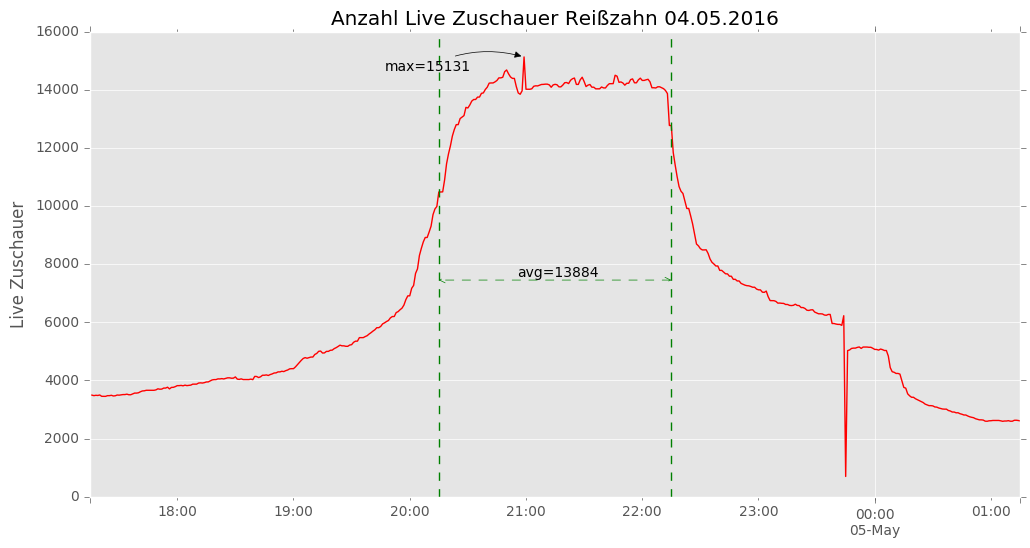

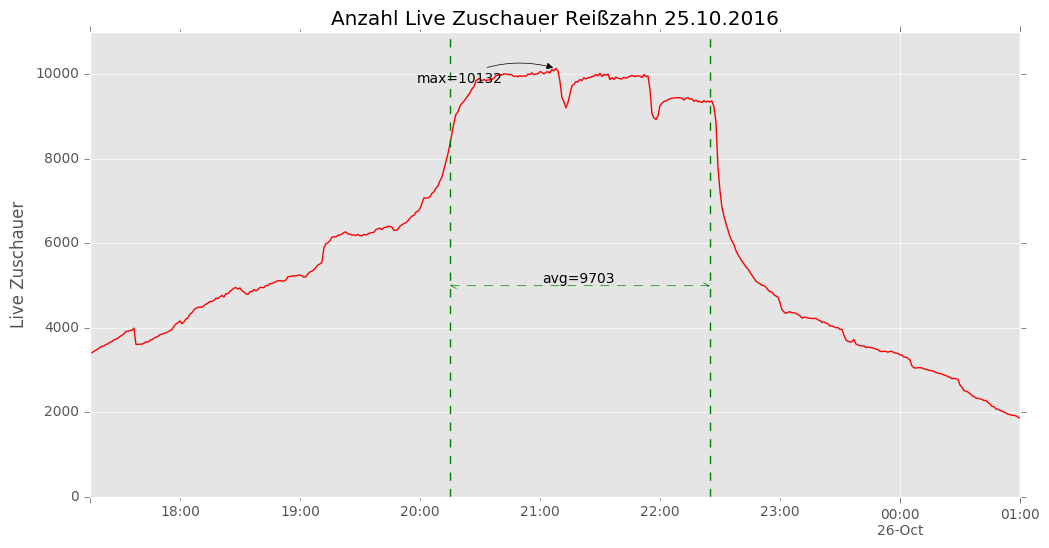

In [5]:
for show in shows:
    #live data (with margin)
    dateStart = show['start'] - margin
    dateEnd = show['end'] + margin
    liveFilteredMargin = live.loc[dateStart : dateEnd]['viewers'].to_frame('viewers')

    #live data (without margin)
    liveFiltered = live.loc[show['start'] : show['end']]['viewers'].to_frame('viewers')
    liveMean = float(liveFiltered.mean())

    #plot
    plot = liveFilteredMargin.plot(figsize=(12, 6), color='r', legend=False, title='Anzahl Live Zuschauer %s' % show['name'])
    plot.set_xlabel('')
    plot.set_ylabel('Live Zuschauer')

    plt.ylim(ymin=0)

    #annotate max
    datapointMax = {
        'x': liveFiltered.idxmax()[0],
        'y': liveFiltered.max()[0]
    }
    plot.annotate('max=%d' % datapointMax['y'], 
                  xy=(datapointMax['x'], datapointMax['y']), xycoords='data', 
                  xytext=(-100, -10), textcoords='offset points',
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle='arc3,rad=-0.2',
                                  linewidth = 0.5,
                                  color = 'black')
                 )

    #annotate avg
    dateMiddle = (show['start'] + (show['end'] - show['start']) / 2)
    plot.annotate('', 
                  xy=(show['start'], datapointMax['y'] / 2.03), xycoords='data', 
                  xytext=(show['end'], datapointMax['y'] / 2.03), textcoords='data',
                  arrowprops=dict(edgecolor='g', arrowstyle = '<->', linestyle='--', shrinkA=0, shrinkB=0)
                  )
    plot.annotate('avg=%d' % liveMean, 
                  xy=(dateMiddle, datapointMax['y'] / 2), xycoords='data', 
                  xytext=(-27, 0), textcoords='offset points')

    #start/end times
    plot.axvline(show['start'], color='g', linestyle='--')
    plot.axvline(show['end'], color='g', linestyle='--')

plot

In [6]:
data = pd.DataFrame(columns=['viewers'])
for show in shows:
    #live data (without margin)
    liveFiltered = live.loc[show['start'] : show['end']]['viewers'].to_frame('viewers')
    liveMean = float(liveFiltered.mean())
    data.loc[show['name']] = liveMean

data

,viewers
Reißzahn 04.05.2016,13884.950413
Reißzahn 25.10.2016,9703.114504


(0, 14000.0)

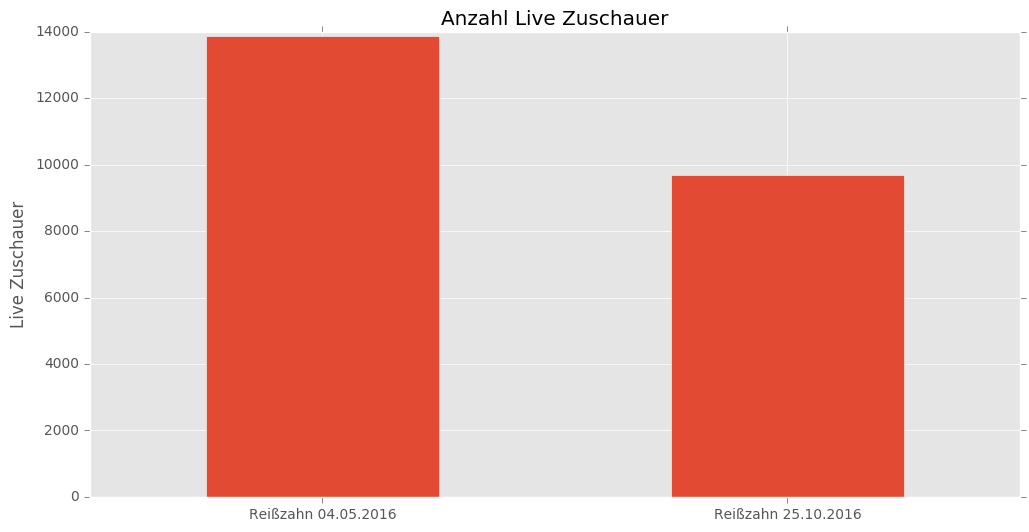

In [7]:
plot = data['viewers'].plot(kind='bar', figsize=(12, 6), title='Anzahl Live Zuschauer')
plot.set_ylabel('Live Zuschauer')

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Chat Nachrichten & Teilnehmer

In [8]:
data = pd.DataFrame(columns=['messages', 'participants', 'ratio'])

for show in shows:
    #live data
    liveFiltered = live.loc[show['start'] : show['end']]['viewers'].to_frame('viewers')
    liveMean = float(liveFiltered.mean())

    #chat data
    chatFiltered = chat.loc[show['start'] : show['end']]
    chatMessages = len(chatFiltered)
    chatParticipants = len(chatFiltered['username'].unique())

    #chat participants to live viewers ratio
    ratio = chatParticipants / liveMean

    data.loc[show['name']] = (chatMessages, chatParticipants, ratio)

data

,messages,participants,ratio
Reißzahn 04.05.2016,38715.0,4224.0,0.304214
Reißzahn 25.10.2016,9514.0,1962.0,0.202203


(0, 40000.0)

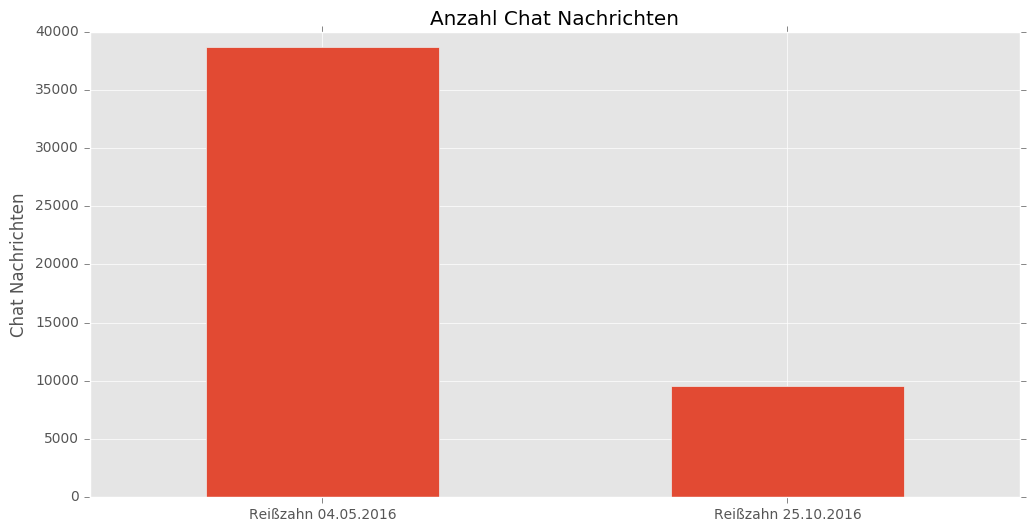

In [9]:
plot = data['messages'].plot(kind='bar', figsize=(12, 6), title='Anzahl Chat Nachrichten')
plot.set_ylabel('Chat Nachrichten')

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 4500.0)

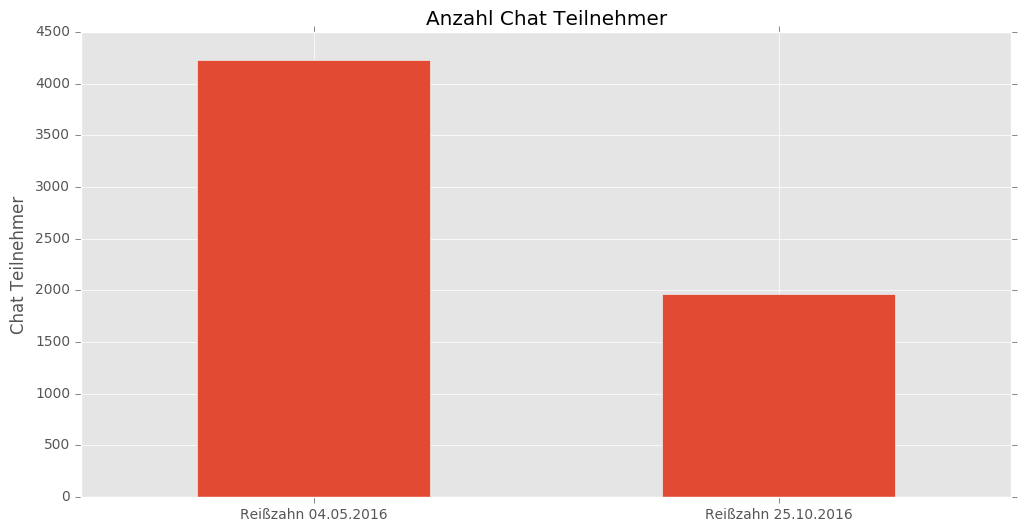

In [10]:
plot = data['participants'].plot(kind='bar', figsize=(12, 6), title='Anzahl Chat Teilnehmer')
plot.set_ylabel('Chat Teilnehmer')

plt.xticks(rotation=0)
plt.ylim(ymin=0)

(0, 0.35000000000000003)

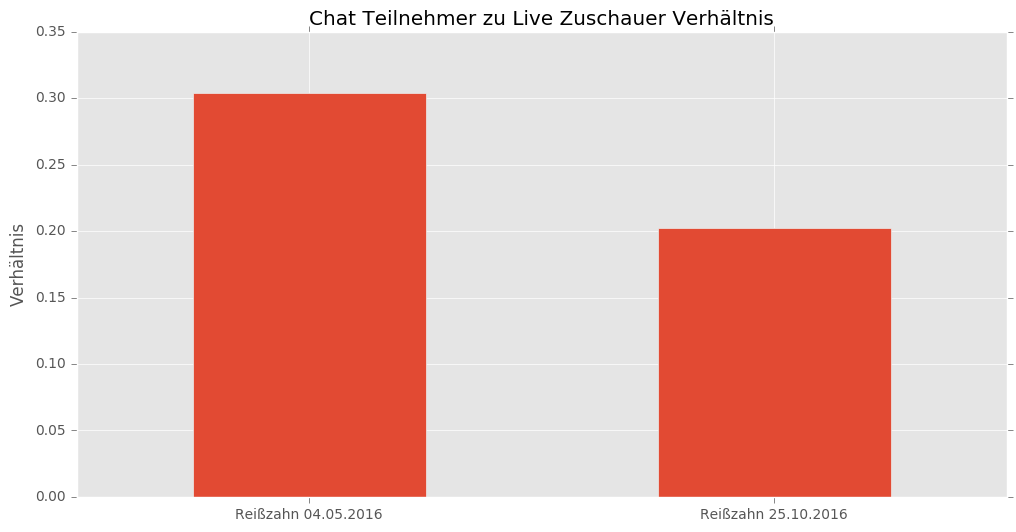

In [11]:
plot = data['ratio'].plot(kind='bar', figsize=(12, 6), title='Chat Teilnehmer zu Live Zuschauer Verhältnis')
plot.set_ylabel('Verhältnis')

plt.xticks(rotation=0)
plt.ylim(ymin=0)

## Relative Änderung

Die relative Änderung bezieht sich auf den Vergleich der durchschnittlichen Live Zuschauer während des Events, mit dem Durchschnitt und Median über einige Wochen aus dem Zeitraum. Je stärker die Änderung, desto stärker hebt sich das Event im Bezug auf die Live-Zuschauer vom üblichen Programm in dem lokalen Zeitraum ab.

In [12]:
data = pd.DataFrame(columns=['viewers', 'comp_mean', 'comp_median', 'change_mean', 'change_median'])
for show in shows:
    #=========== event time ===========
    #live data (event time)
    liveFiltered = live.loc[show['start'] : show['end']]['viewers'].to_frame('viewers')
    liveMean = float(liveFiltered.mean())

    #=========== comparision period ===========
    #start/end date (comparision period)
    startDate = show['start'] + datetime.timedelta(days=-show['start'].weekday(), weeks=-spanLeft)
    startDate = startDate.replace(hour=0, minute=0, second=0)
    endDate = show['start'] + datetime.timedelta(days=6 - show['start'].weekday(), weeks=spanRight)
    endDate = endDate.replace(hour=11, minute=59, second=59)

    #live data (comparision period)
    liveFiltered = live.loc[startDate : endDate]

    if comparison == ComparisonType.week:
        #no additional filter necessary
        pass
    elif comparison == ComparisonType.week_no_weekend:
        workingDays = range(0,5)
        liveFiltered = liveFiltered[liveFiltered['weekday'].isin(workingDays)]
    elif comparison == ComparisonType.weekday:
        liveFiltered = liveFiltered[liveFiltered['weekday'] == show['date'].weekday()]
    
    liveGrouped = liveFiltered.groupby('day')
    compLiveMean = liveGrouped.apply(lambda group: group['viewers'].mean())
    compLiveMean = compLiveMean.to_frame('viewers')

    #calculate mean & median (comparision period)
    compMean = float(compLiveMean.mean())
    compMedian = float(compLiveMean.median())

    #=========== change ===========
    #calculate change (mean)
    changeMean = 100 * (liveMean - compMean) / compMean

    #calculate change (median)
    changeMedian = 100 * (liveMean - compMedian) / compMedian    

    data.loc[show['name']] = (liveMean, compMean, compMedian, changeMean, changeMedian)

data

,viewers,comp_mean,comp_median,change_mean,change_median
Reißzahn 04.05.2016,13884.950413,3534.729861,3574.277778,292.815037,288.468700
Reißzahn 25.10.2016,9703.114504,2432.908101,2395.904861,298.827827,304.987471


(0, 350.0)

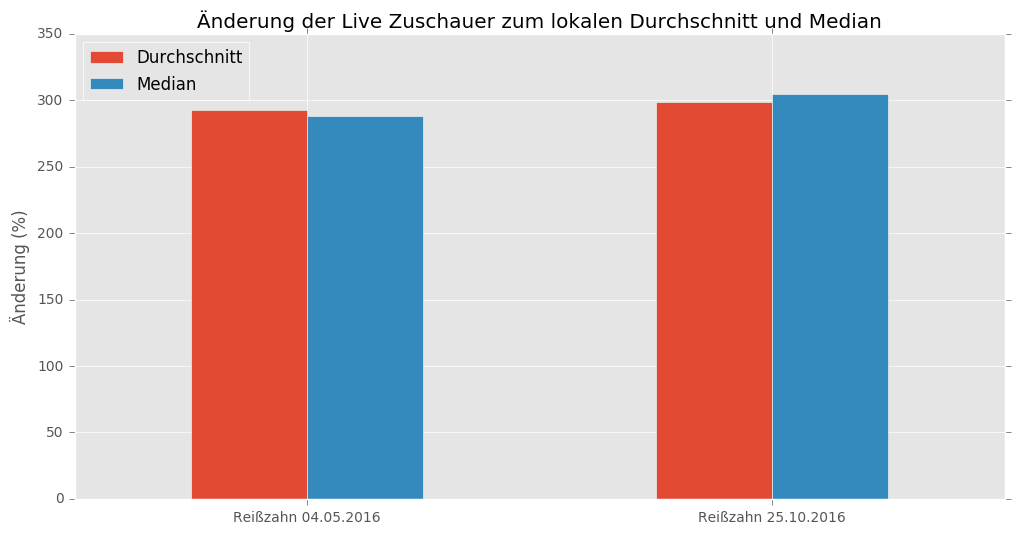

In [13]:
plot = data[['change_mean', 'change_median']].plot(kind='bar', figsize=(12, 6), title='Änderung der Live Zuschauer zum lokalen Durchschnitt und Median')
plot.set_ylabel('Änderung (%)')

legend = plot.legend(loc=0)
legend.get_texts()[0].set_text('Durchschnitt')
legend.get_texts()[1].set_text('Median')

plt.xticks(rotation=0)
plt.ylim(ymin=0)